In [1]:
import pickle
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

##  شبکه عصبی Forward Feed:
در فاز اول پروژه پنجم به پیاده سازی شبکه‌های عصبی Forward Feed جهت طبقه‌بندی تصاویر پرداخته شده است.
هر تصویر ابتدا مسطح شده و به صورت بردار به عنوان ورودی شبکه داده میشود. هر درایه این بردار (معادل با یک پیکسل تصویر) یک ویژگی برای آن محسوب می‌شود. شبکه قرار است براساس این ویژگی‌ها و با ساختن ترکیبات غیرخطی از آنها، وزن اتصالات بین لایه‌هایش را طوری تنظیم کند، که خروجی آن ضمن داشتن کمترین خطا، کلاس تصویر ورودی متناظر را به درستی پیش‌بینی کند.  
##  معرفی مجموعه داده
مجموعه داده شامل تصاویری از 10 رقم 0 تا 9 در زبان فارسی است. در مجموع 102352 تصویر در این مجموعه داده موجود است.
![alt text](handwriten.png "Title")

In [2]:
pkl_file = open('dataset/data.pkl', 'rb')
data = pickle.load(pkl_file)

In [3]:
pkl_file = open('dataset/labels.pkl', 'rb')
labels = pickle.load(pkl_file)

In [4]:
HEIGHT = 25
WIDTH = 25
IMAGE_SHAPES = (HEIGHT, WIDTH)
length = len(data)

##  بخش اول: بررسی و پیش‌پردازش داده

*  ابتدا به صورت random یک عکس انتخاب شده و سپس مقادیر نقاط عکس توسط متد bar رسم شده است همان‌طور که در شکل مشخص است مقدار هر pixel در بازه صفر و یک قرار دارد.

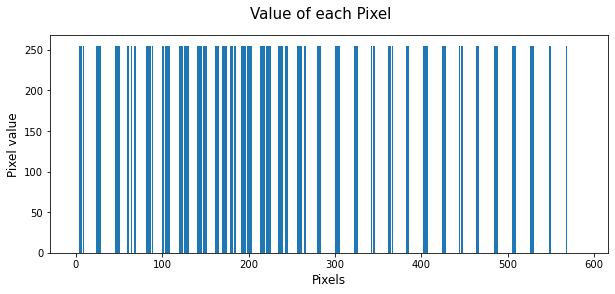

In [5]:
samples_idx = random.choices(range(length))[-1]
fig = plt.figure(figsize=(10, 4))
img = data[samples_idx].reshape(1, -1)[-1]
plt.bar(range(img.size), img)
plt.xlabel('Pixels', fontsize = 12)
plt.ylabel('Pixel value', fontsize = 12)
plt.suptitle('Value of each Pixel', fontsize = 15)
plt.show()

*  به کمک متد resize از کتابخانه OpenCV طول و عرض هر تصویر به 25 تغییر داده شده است.

In [6]:
data = [cv2.resize(img,IMAGE_SHAPES,interpolation=cv2.INTER_AREA) for img in data]

In [7]:
classes = np.unique(labels)

*  در مجموعه داده train ،از هر کلاس به دلخواه سه تصویر انتخاب و به همراه نوع آن نمایش داده شده است.

In [8]:
X_train = np.array(data[:80000])
y_train = np.array(labels[:80000])

X_test = np.array(data[80000:])
y_test = np.array(labels[80000:])

print('Train data shape:        ', X_train.shape)
print('Train labels shape:      ', y_train.shape)

print('Test data shape:         ', X_test.shape)
print('Test labels shape:       ', y_test.shape)


Train data shape:         (80000, 25, 25)
Train labels shape:       (80000,)
Test data shape:          (22352, 25, 25)
Test labels shape:        (22352,)


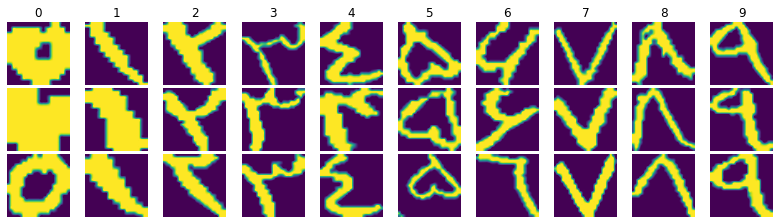

In [9]:
plt.figure(figsize=(12, 3))
plt.subplots_adjust(0, 0, 0.9, 0.9, wspace=0.05, hspace=0.05)
samples_per_class = 3
num_classes = len(classes)
for c in classes:
    idxes = np.flatnonzero(y_train == c)
    samples_idxes = np.random.choice(idxes, samples_per_class, replace=False)
    for i, idx in enumerate(samples_idxes):
        plt_idx = i * num_classes + c + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(HEIGHT,WIDTH).astype(np.uint8), interpolation='spline16')
        plt.axis('off')
        if i == 0:
            plt.title(c)

*  تعداد تصاویر هر دسته را برای مجموعه داده train و test محاسبه و نمودار میله‌ای آن رسم شده است.

In [10]:
train_label, train_count = np.unique(y_train, return_counts=True)
_ , test_count = np.unique(y_test, return_counts=True)

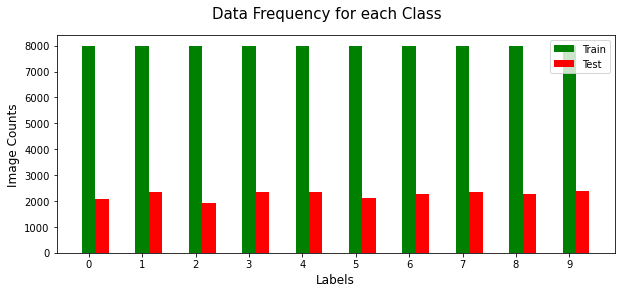

In [11]:
barWidth = 0.25
fig = plt.figure(figsize=(10, 4))
test_label = [x + barWidth for x in train_label]
plt.bar(train_label, train_count, color ='g', width = 0.25,label ='Train') 
plt.bar(test_label, test_count, color ='r', width = 0.25 ,label ='Test')
plt.xlabel('Labels', fontsize = 12)
plt.ylabel('Image Counts', fontsize = 12)
plt.suptitle('Data Frequency for each Class', fontsize = 15)
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))
plt.legend()
plt.show()

In [12]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test  = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape:   ', X_train.shape)
print('Test data shape:       ', X_test.shape)

Training data shape:    (80000, 625)
Test data shape:        (22352, 625)


*  شبکه های عصبی ورودی ها را با استفاده از مقادیر وزن کوچک پردازش می کنند و ورودی هایی با مقادیر صحیح بزرگ می توانند فرآیند یادگیری را مختل یا کند کنند به این ترتیب، نرمال سازی مقادیر پیکسل به گونه ای که مقدار هر پیکسل مقداری بین 0 و 1 داشته باشد، ایده خوبی می باشد که در ادامه کد آن آمده است.

In [13]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

## بخش دوم: تکمیل بخشهای ناقص شبکه عصبی
در ادامه کدهای ناقص تکمیل شده است.

In [14]:
class Dataloader:
    '''
    This class prepares the dataset for the neural network.
    '''
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        '''
        This is the constructor. It gets dataset information and initializes the 
        Dataloader class fields.
            Parameters:
                data: features your dataset in pandas.Dataframe format.
                labels: labels of your dataset in pandas.Dataframe format.
                n_classes: number of classes you have in your dataset.
                batch_size: the number of samples that will be propagated through the network.
                shuffle: boolean value indicating whether or not the dataset should be shuffled
        '''

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        '''
        This private method gets labels and provides one_hot vectors of labels.
        For categorical variables where no such ordinal relationship exists,
        the integer encoding is not enough.
        In this case, a one-hot encoding can be applied to the integer representation.
        This is where the integer encoded variable is removed, and a new binary variable is
        added for each unique integer value.
        example:
            red,    green,    blue
            1,      0,        0
            0,      1,        0
            0,      0,        1
                Parameters:
                        label: lables of your dataset in pandas.Dataframe format.
                        n_classes: number of classes you have in your dataset.
                
                Returns:
                    onehot_vectors: onehot vectors of the labels
        '''
        # TODO: Implement
        labels = labels.astype(int)
        onehot_vectors = np.zeros((labels.size, n_classes))
        onehot_vectors[np.arange(labels.size), labels] = 1.0
        return onehot_vectors
    
    def __shuffle_dataset(self):
        '''
        This private method shuffles your dataset.
        It uses data and onehot_labels to shuffle them
        symmetrical.
        '''
        # TODO: Implement
        total_data = np.c_[self.__data.reshape(len(self.__data), -1), \
                          self.__onehot_labels.reshape(len(self.__onehot_labels), -1)]
        np.random.shuffle(total_data)
        data = total_data[:, :self.__data.size//len(self.__data)].reshape(self.__data.shape)
        self.__onehot_labels = total_data[:, self.__data.size//\
                                          len(self.__data):].reshape(self.__onehot_labels.shape)
        self.__data = data
    
    def __iter__(self):
        '''
        The __iter__() function returns an iterator for the
        given object (array, set, tuple, etc., or custom objects).
        This will return your dataset in the batch_size given. This should
        be used to provide data for the neural network.
        '''
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

###  توابع فعال‌ساز
####  تابع واحد یک‌سوشده‌ی خطی (ReLU / Rectified Linear Unit)  
تابع فعالساز واحد یک‌سوشده‌ی خطی در زمینه‌ی یادگیری عمیق بسیار مشهور است و در بیشتر مواقع استفاده می‌شود. این تابع به‌این صورت عمل می‌کند که مقادیر منفی (زیر صفر) را صفر و مقادیر مثبت (بیشتر از صفر) و مقادیر برابر با صفر را همان مقدار خودش در نظر می‌گیرد.  

*  مزایا:  
از نظر محاسباتی بسیار کارآمد است و به شبکه اجازه می‌دهد به‌سرعت همگرا شود؛ زیرا رابطه‌ی آن خطی است و به‌همین دلیل، در مقایسه با تابع‌های سیگموید و Tanh، سریع‌تر است.  
*  معایب:  
مشکل مرگ نورون یا مرگ ReLU دارد؛ یعنی زمانی‌که ورودی صفر یا نزدیک به صفر باشد، تابع ReLU دیگر عملکردی ندارد و به‌بیان دیگر، می‌میرد. در این صورت، مقدار گرادیان تابع صفر می‌شود و شبکه نمی‌تواند عملیات پس انتشار (Backpropagation) را انجام دهد و آموزش ببیند.  
خروجی این تابع صفر یا مثبت است و این یعنی صفرمحور نیست.  
![alt text](Relu.png "Title")
####  تابع فعالساز Leaky ReLU  
این تابع فعالساز برای حل مشکل اصلی تابع ReLU ارائه شده است. در شکل بعدی نمایی از این تابع را مشاهده می‌کنیم:  

*  مزایا  
از مشکل مرگ ReLU جلوگیری می‌کند. این تابع یک شیب مثبت ملایم به‌سمت مقادیر منفی دارد که این امر باعث می‌شود عملیات پس انتشار (Backpropagation) حتی برای مقادیر منفی هم انجام شود.  
*  معایب  
برای مقادیر منفی پیش‌بینی (خروجی) ثابتی را ارائه نمی‌کند.  
در حین عملیات انتشار روبه‌جلو (Forward Propagation) اگر نرخ یادگیری (Learning Rate) را خیلی بالا در نظر بگیریم، مشکل مرگ نورون‌ها را رقم می‌زند.  
![alt text](LeakyRelu.png "Title")
####  تابع سیگموید (Sigmoid)  
این تابع یک منحنی S شکل است. زمانی‌که می‌خواهیم خروجی مدل احتمال باشد، از تابع سیگموید استفاده می‌کنیم؛ چون تابع سیگموید مقادیر را به بازه صفر تا ۱ می‌برد و احتمالات هم میان همین بازه قرار دارند.

*  مزایا  
این تابع تمایزپذیر (Differentiable) است؛ یعنی در هر قسمت از منحنی می‌توانیم شیب میان دو نقطه را حساب کنیم.  
از آنجا که این تابع مقادیر را میان صفر و یک قرار می‌دهد، نوعی عادی‌سازی را برای خروجی هر نورون انجام می‌دهد.  
*  معایب  
با محوشدگی گرادیان (Vanishing Gradient) مقادیر بسیار بزرگ یا بسیار کوچک x، مشتق بسیار کوچک می‌شود و درواقع شبکه دیگر آموزش نمی‌بیند و پیش‌بینی‌هایش در خروجی ثابت می‌ماند.  
به‌دلیل مشکل محوشدگی‌گرادیان، تابع سیگموید هم‌گرایی کند دارد.  
خروجی تابع سیگموید صفرمحور (Zero-Centered) نیست؛ این امر کارایی به‌روزرسانی وزن‌ها را کم می‌کند.  
از آنجا که این تابع عملیات نمایی (Exponential Operations) دارد، می‌توان گفت هزینه‌ی محاسباتی بالایی دارد و کندتر پیش می‌رود.  
![alt text](Sigmoid.png "Title")
####  تابع تانژانت هایپربولیک (Tanh, Hyperbolic Tangent)  
این تابع هم مانند تابع سیگموید به‌شکل S است، اما در مقایسه با تابع سیگموید، نکات مثبت بیشتری دارد.  

*  مزایا  
این تابع صفرمحور است؛ بنابراین به مدل کمک می‌کند تا مقادیر ورودی منفی، خنثی و مثبت داشته باشد؛ به‌عبارت دیگر، مقادیر منفی، به‌شدت منفی و مقادیر صفر در گراف تانژانت هایپربولیک نزدیک به صفر نگاشت می‌شوند.  
تابع و مشتق آن هر دو یکنواخت (Monotonic) هستند.  
*  معایب  
محوشدگی گرادیان  
هم‌گرایی کند  

![alt text](Tanh.png "Title")


In [15]:
class Identical:
    '''
    This is the Identical activation function. This activation function just
    return the value it gets.
    '''
    
    def __init__(self): pass

    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        As this is an identical activity function, it just 
        returns np.matrix of the input.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_value: np.matrix of input with float datatypes
        '''
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        '''
        This method returns the derivation of the input.
        As the derivation of x is one, this method returns
        a matrix of one with the shape of the input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_derivative: np.matrix of ones with matrix shape
        '''
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.0))
        return identical_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _value method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    

class Relu:
    '''
    This is the Relu activation function. 
    The rectified linear activation function or ReLU for short
    is a piecewise linear function that will output the input directly
    if it is positive, otherwise, it will output zero.
    '''
    
    def __init__(self): pass

    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set 0 in the matrix if the value is less than 0 else, it returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        temp = np.matrix(matrix, dtype=float)
        relu_value = np.matrix(np.maximum(temp, 0.))
        return relu_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_derivative: np.matrix of relu activation function derivation result
        '''
        # TODO: Implement
        relu_derivative = np.matrix(matrix, dtype=float)
        relu_derivative[relu_derivative <= 0] = 0.
        relu_derivative[relu_derivative > 0] = 1.
        return relu_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _relu method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __relu(matrix): __relu return value for the input matrix
        '''
        return self.__val(matrix)

    
class LeakyRelu:
    '''
    This is the Leaky Relu activation function. 
    Leaky Rectified Linear Unit, or Leaky ReLU,
    is a type of activation function based on a ReLU,
    but it has a small slope for negative values instead
    of a flat slope.
    '''
    
    def __init__(self, negative_slope=0.01):
        '''
        This is the constructor.
        It sets negative_slope field.
            Parameters:
                negative_slope: slope for negative input values
        '''
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set negative_slope*value in the matrix if the value is less than 0, else it
        returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        temp = np.matrix(matrix, dtype=float)
        leacky_relu_value = np.matrix(np.where(temp > 0, temp, temp * self.negative_slope))
        return leacky_relu_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of leaky relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                leacky_relu_derivative: np.matrix of leaky relu activation function derivation result
        '''
        # TODO: Implement
        temp = np.matrix(matrix, dtype=float)
        leacky_relu_derivative = np.ones_like(temp)
        leacky_relu_derivative[temp <= 0] = self.negative_slope
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

    
class Sigmoid:
    '''
    A sigmoid function is a mathematical function having a
    characteristic "S"-shaped curve or sigmoid curve.
    It return S(x)=1/(1+e^-x)
    '''
    
    def __init__(self): pass

    def __val(self, matrix):
        '''
        Returns 1/(1+e^-x) of values
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        temp = np.matrix(matrix, dtype=float)
        sigmoid_value = np.matrix(1.0/(1.0 + np.exp(-temp)))
        return sigmoid_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of sigmoid function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of sigmoid activation function derivation result
        '''
        # TODO: Implement
        sigmoid_derivative = np.multiply(self.__val(matrix), (1. - self.__val(matrix)))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)


class Softmax:
    '''
    The softmax function, also known as softargmax  or normalized
    exponential function is a generalization of the logistic
    function to multiple dimensions. It is used in multinomial logistic
    regression and is often used as the last activation function of a neural
    network to normalize the output of a network to a probability distribution
    over predicted output classes, based on Luce's choice axiom.
    Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
    '''
        
    def __init__(self): pass


    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the softmax on that.
        Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        temp = np.matrix(matrix, dtype=float)
        softmax_value = np.exp(temp - np.max(temp))
        softmax_value /= softmax_value.sum(axis=1)
        return softmax_value
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self): pass


    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It performs Tanh on the values.

            Parameters:
                matrix: np.matrix of values
            Returns:
                tanh_value: np.matrix of Tanh activation function result
        '''
        # TODO: Implement
        temp = np.matrix(matrix, dtype=float)
        tanh_value = np.matrix((np.exp(temp) - np.exp(-temp))/(np.exp(temp) + np.exp(-temp)))
        return tanh_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of Tanh function on input matrix.

            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of Tanh activation function derivation result
        '''
        # TODO: Implement
        tanh_derivative = 1 - np.power(self.__val(matrix), 2)
        return tanh_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.

            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

In [16]:
class CrossEntropy: #(with softmax)
    '''
    Cross-entropy is a measure of the difference between two probability
    distributions for a given random variable or set of events. You might
    recall that information quantifies the number of bits required to encode
    and transmit an event.
    The above image can help you.
    '''
    
    def __init__(self): pass
    '''
    This is the constructor. It does not have any fields
    as a result, there is no need to do anything in the constructor.
    '''

    def __val(self, true_val, expected_val):
        '''
        L(y^, y) = - Σ (y^(k)log (y^)^(k)) for k in K
        Parameters:
            true_val: calculated values (generated by neural network)
            expected_val: real values in dataset
        Returns:
            cross_entropy_value: cross entropy of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
        # TODO: Implement
        softmax = Softmax()
        cross_entropy_value = np.sum(-np.multiply(np.matrix(expected_val, dtype=float), \
                                                  np.log(softmax(true_val))), axis=1)
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        '''
        Returns derivation of cross entropy.
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                cross_entropy_derivative: cross entropy derivation of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
        # TODO: Implement
        softmax = Softmax()
        cross_entropy_derivative = softmax(true_val) - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(true_val, expected_val)

In [17]:
class Layer:
    '''
    The layer class is used to define neural network layers.
    It stores all needed information for each layer, such as neurons count,
    weight matrix, bias, the output after applying the activation function, etc.
    '''

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, activation=Identical(), initial_weight='uniform', 
                 **initializing_parameters):
        '''
        Parameters:
            input_size: the size of the input of this layer.
            output_size: the size of the output after this layer.
            activation: the activation function. It can be initialized to either of the previously defined activation classes.
                               default is an Identical activation function.
            initial_weight: either normal or uniform. It defines the method for weight initialization.
        '''
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        '''
        It calculates the output of this layer for the layer_input argument.
        This method also stores __last_input, __last_activation_input, and __last_activation_derivative
        for future use in backpropagation.
        Parameters:
            layer_input: 2d np.matrix representing the input matrix of this layer.
        Returns:
            Final output of this layer after applying the activation function.
        '''
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        # TODO: Implement
        self.__last_input = layer_input
        self.__last_activation_input = np.add(np.dot(self.__last_input, self.__weight), self.__bias)
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_output)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        '''
        It updates Layer weights according to the backpropagation matrix and learning rate.
        This method updates bias values as well.
        Parameters:
            backprop_tensor: 2d np.matrix passed from the next layer containing gradient values.
            lr: learning rate
        Returns:
            backprop_tensor to be used by the previous layer.
        '''
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        # TODO: Implement
        backprop_tensor = np.multiply(backprop_tensor, self.__last_activation_derivative)
        self.__weight -= (lr * np.dot(self.__last_input.T, backprop_tensor))
        self.__bias -= (lr * np.dot(np.ones((1, backprop_tensor.shape[0])), \
                                                                      backprop_tensor))
        backprop_tensor = np.dot(backprop_tensor, self.__weight.T)
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a uniform distribution between low and high values.
        It uses default low and high values unless low or high are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom low or high values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using uniformly distributed values.
        '''
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        # TODO: Implement
        weights = np.random.uniform(low, high=high, size=(dim1, dim2))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a normal distribution with mean and var values.
        It uses default mean and variance values unless mean or var are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom mean or var values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using normaly distributed values.
        ''' 
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        # TODO: Implement
        weights = np.random.normal(loc=mean, scale=var, size=(dim1, dim2))
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

In [18]:
class FeedForwardNN:
    '''
    This class is used in order to implement custom feed-forward neural networks.
    The FeedForwardNN class stores a list of layers that determines all network layers.
    It also consists of the learning rate and loss function.
    '''
    def __init__(self, input_shape):
        '''
        Parameters:
            input_shape: the size of the first input to our neural network.
        '''

        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None
        
        self.__before_last = None
        self.__before_last_train = None
        self.__before_last_test = None
        
        self.__train_labels = None
        self.__test_labels = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
        '''
         This method adds a new custom layer to the layers_list.
         Parameters:
             n_neurons: number of neurons in this layer
             activation: the activation function of this layer, default is Relu
             initial_weight: either a uniform or normal, default is uniform
             initializing_parameters: other initializing parameters such as low, high, mean, var, etc
        '''
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        '''
        This method is used to set training parameters.
        Parameters:
            loss: loss function, default is CrossEntropy
            lr: learning rate, default is 1e-3
        '''
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        '''
        This method calculates the output of the complete neural network for a passed input.
        Parameters:
            network_input: input of the neural network
        Returns:
            network_output: output of the neural network after forwarding the network_input
        '''
        assert type(self.__output_shape) != None, "Model is not compiled!"
        # TODO: Implement
        network_output = network_input
        for i in range(len(self.__layers_list)):
            network_output = self.__layers_list[i].forward(network_output)
            if i == (len(self.__layers_list)-2):
                self.__before_last = network_output
        return network_output
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        '''
        This method trains the neural network using specified parameters.
        It runs the __train private method epoch times and fills the log dictionary.
        Parameters:
            epochs: number of epochs to run
            trainloader: DataLoader for train data
            testloader: DataLoader for test data
            print_results: whether or not to print the results
        Returns:
            log: complete log of the training process as a dictionary consisting of
            train_accuracy, train_loss, test_accuracy, test_loss
        '''
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        '''
        Trains the neural network for one epoch.
        Parameters:
            trainloader: A DataLoader consisting of train data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        '''
        Test the neural network using a testloader.
        Parameters:
            testloader: A DataLoader of test data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        '''
        Trains the neural network for one batch of train data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''
        # TODO: Implement
        output = self.forward(x_batch)
        self.__update_weights(output, y_batch)
        batch_accuracy = self.__compute_accuracy(output, y_batch)
        batch_average_loss = np.mean(self.__loss(output, y_batch))
        if type(self.__before_last_train) is not np.matrix:
            self.__before_last_train = self.__before_last
        else:
            self.__before_last_train = np.concatenate((self.__before_last_train, \
                                                       self.__before_last), axis=0)
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        '''
        Tests the neural network for one batch of test data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''  
        # TODO: Implement
        output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(output, y_batch)
        batch_average_loss = np.mean(self.__loss(output, y_batch))
        if type(self.__before_last_test) is not np.matrix:
            self.__before_last_test = self.__before_last
        else:
            self.__before_last_test = np.concatenate((self.__before_last_test, \
                                                       self.__before_last), axis=0)
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        '''
        Parameters:
            outputs: output of the neural network
        Returns:
            labels: labels generated from the outputs of the neural network
        '''
        # TODO: Implement
        labels = np.argmax(outputs, axis = 1)
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        '''
        Computes accuracy by comparing output and expected_output.
        Parameters:
            output: actual output of the neural network
            expected_output: expected output
        Returns:
            accuracy
        '''
        # TODO: Implement
        accuracy = (self.__get_labels(output) == self.__get_labels(expected_output)).sum()/output.shape[0]
        accuracy *= 100
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        '''
        Updates weights of all layers according to neural network output and labels.
        Parameters:
            output: output of the neural network
            y_train: y labels for one batch of train data
        Returns:
            None
        '''
        # TODO: Implement
        for i in reversed(range(len(self.__layers_list))):
            if i == (len(self.__layers_list) - 1):
                backprop_tensor = self.__layers_list[i].\
                update_weights(self.__loss.derivative(output, y_train), self.__lr)
            else:
                backprop_tensor = self.__layers_list[i].update_weights(backprop_tensor, self.__lr)
        return

##  بخش سوم: طبقه بندی داده ها
###  قسمت اول) آموزش شبکه
مقدار lr برابر با 0.0001 فرض شده است باقی مقادیر مطابق پیشنهاد سوال می باشد. 

In [19]:
INPUT_SHAPE = HEIGHT * WIDTH
LEARNING_RATE = 1e-4
EPOCHS = 15
BATCH_SIZE = 32
N_CLASSES = 10

TRAINLOADER = Dataloader(X_train, y_train, N_CLASSES, BATCH_SIZE)
TESTLOADER = Dataloader(X_test, y_test, N_CLASSES, BATCH_SIZE)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Relu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)


Epoch 1:
	Train: Average Accuracy: 61.2875	Average Loss: 1.2012658463294508
	Test: Average Accuracy: 26.260729613733904	Average Loss: 3.147697010599646
Epoch 2:
	Train: Average Accuracy: 90.145	Average Loss: 0.3545610706326102
	Test: Average Accuracy: 52.315808297567955	Average Loss: 1.8872015857699591
Epoch 3:
	Train: Average Accuracy: 93.555	Average Loss: 0.22558426995667083
	Test: Average Accuracy: 60.93079399141631	Average Loss: 1.3934655431997893
Epoch 4:
	Train: Average Accuracy: 94.93625	Average Loss: 0.18071258662285167
	Test: Average Accuracy: 66.75608011444922	Average Loss: 1.1193831895779212
Epoch 5:
	Train: Average Accuracy: 95.53375	Average Loss: 0.15976354531834921
	Test: Average Accuracy: 71.09710300429184	Average Loss: 0.9501728894410029
Epoch 6:
	Train: Average Accuracy: 95.84	Average Loss: 0.14738981629254802
	Test: Average Accuracy: 74.15504291845494	Average Loss: 0.8317241068993997
Epoch 7:
	Train: Average Accuracy: 96.095	Average Loss: 0.138907415883191
	Test: Aver

###  قسمت دوم) وزن‌دهی شبکه
مقدار اولیه وزن‌ها در آموزش شبکه اهمیت زیادی دارد مثلا اگر ابتدا مقدار صفر به وزن ­ها نسبت داده ­شود. تمام نرون ­ها در تمام لایه ­ها محاسبات یکسانی را اجرا می­ کنند و خروجی مشابه حاصل می ­کنند. خروجی بدست ­آمده باتوجه به تابع هزینه برای هر وزنی مشابه است و درنتیجه مدل چیزی یاد نخواهد گرفت و وزن­ ها بروزرسانی نخواهد شد.
*  توزیع Normal:
مهمترین توزیع پیوسته در آمار و احتمال توزیع نرمال است. نموار این توزیع همانطور که در شکل مشاهده می‌کنید کاملا نسبت به یک حد متوسط μ متقارن است و به این منحنی که مانند زنگوله است منحنی نرمال می‌گویند.
![alt text](normal.png "Title")
اغلب متغیرهای تصادفی پیوسته در طبیعت و صنعت دارای نموداری مانند نمودار منحنی نرمال هستند در صورت انتخاب توزیع نرمال، وزن های شبکه‌ی عصبی به صورت تصادفی با توزیع نرمال مقداردهی می شوند.

*  توزیع uniform: 
ساده ترین توزیع احتمال توزیع uniform یا یکنواخت است که در آن احتمال رخ داد مقادیر مختلف متغیر تصادفی X برابر است ر صورت انتخاب توزیع یکنواخت، وزن های شبکه‌ی عصبی به صورت تصادفی با مقدارهای تقریبا برابر مقداردهی می شوند.
![alt text](uniform.png "Title")

###  قسمت سوم) تاثیر learning rate
یکی از پارامتر های مهم در آموزش دادن شبکه های عصبی، rate learning می باشد.
*  در این قسمت وقتی نرخ بهینه یادگیری در 0.1 ضرب شده، بنابراین سرعت فرآیند یادگیری کاهش یافته و به نظر می‌رسد که برای همگرایی به بالاترین دقت به EPOCH بیشتری نیاز است.

In [20]:
INPUT_SHAPE = HEIGHT * WIDTH
LEARNING_RATE = 1e-4 * 0.1
EPOCHS = 15
BATCH_SIZE = 32
N_CLASSES = 10

TRAINLOADER = Dataloader(X_train, y_train, N_CLASSES, BATCH_SIZE)
TESTLOADER = Dataloader(X_test, y_test, N_CLASSES, BATCH_SIZE)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Relu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)


Epoch 1:
	Train: Average Accuracy: 26.00625	Average Loss: 1.9466167864942108
	Test: Average Accuracy: 10.604434907010015	Average Loss: 4.685703750332942
Epoch 2:
	Train: Average Accuracy: 26.96875	Average Loss: 1.9282310809032874
	Test: Average Accuracy: 10.604434907010015	Average Loss: 4.597216813228569
Epoch 3:
	Train: Average Accuracy: 30.35125	Average Loss: 1.8423417777817326
	Test: Average Accuracy: 10.604434907010015	Average Loss: 4.3394631437224955
Epoch 4:
	Train: Average Accuracy: 46.36	Average Loss: 1.6391387325496158
	Test: Average Accuracy: 10.604434907010015	Average Loss: 3.7566392720692785
Epoch 5:
	Train: Average Accuracy: 62.18375	Average Loss: 1.3549613945765966
	Test: Average Accuracy: 19.863197424892704	Average Loss: 3.020347453533897
Epoch 6:
	Train: Average Accuracy: 74.4	Average Loss: 1.104534615345808
	Test: Average Accuracy: 27.713698140200286	Average Loss: 2.4004652637568813
Epoch 7:
	Train: Average Accuracy: 80.02375	Average Loss: 0.9084905171834194
	Test: Ave

*  اگر نرخ یادگیری بزرگ انتخاب شود، با گام‌های بلندتری به سمت مینیمم حرکت خواهیم کرد در این قسمت، با ضرب نرخ یادگیری بهینه در 10، مشاهده شد که بین دقت های دوره های مختلف تغییر کوچکی وجود دارد و الگوریتم همگرا نشد.

In [21]:
INPUT_SHAPE = HEIGHT * WIDTH
LEARNING_RATE = 1e-4 * 10
EPOCHS = 15
BATCH_SIZE = 32
N_CLASSES = 10

TRAINLOADER = Dataloader(X_train, y_train, N_CLASSES, BATCH_SIZE)
TESTLOADER = Dataloader(X_test, y_test, N_CLASSES, BATCH_SIZE)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Relu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 9.995	Average Loss: 2.310248802116887
	Test: Average Accuracy: 9.267703862660944	Average Loss: 2.302585092994046
Epoch 2:
	Train: Average Accuracy: 10.0	Average Loss: 2.3025850929940455
	Test: Average Accuracy: 9.267703862660944	Average Loss: 2.302585092994046
Epoch 3:
	Train: Average Accuracy: 10.0	Average Loss: 2.3025850929940455
	Test: Average Accuracy: 9.267703862660944	Average Loss: 2.302585092994046
Epoch 4:
	Train: Average Accuracy: 10.0	Average Loss: 2.3025850929940455
	Test: Average Accuracy: 9.267703862660944	Average Loss: 2.302585092994046
Epoch 5:
	Train: Average Accuracy: 10.0	Average Loss: 2.3025850929940455
	Test: Average Accuracy: 9.267703862660944	Average Loss: 2.302585092994046
Epoch 6:
	Train: Average Accuracy: 10.0	Average Loss: 2.3025850929940455
	Test: Average Accuracy: 9.267703862660944	Average Loss: 2.302585092994046
Epoch 7:
	Train: Average Accuracy: 10.0	Average Loss: 2.3025850929940455
	Test: Average Accuracy: 9.267703862660

###  قسمت چهارم)  تاثیر activation function
*  تابع فعالساز Sigmoid:

In [22]:
INPUT_SHAPE = HEIGHT * WIDTH
LEARNING_RATE = 1e-4
EPOCHS = 15
BATCH_SIZE = 32
N_CLASSES = 10

TRAINLOADER = Dataloader(X_train, y_train, N_CLASSES, BATCH_SIZE)
TESTLOADER = Dataloader(X_test, y_test, N_CLASSES, BATCH_SIZE)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Sigmoid(), weight_initializer='uniform')
network.add_layer(10, activation=Sigmoid(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 10.22875	Average Loss: 2.3022170219317544
	Test: Average Accuracy: 10.573140200286122	Average Loss: 2.302316830172998
Epoch 2:
	Train: Average Accuracy: 10.2375	Average Loss: 2.3022105168242133
	Test: Average Accuracy: 10.604434907010015	Average Loss: 2.3022612654916133
Epoch 3:
	Train: Average Accuracy: 10.2375	Average Loss: 2.302235320268319
	Test: Average Accuracy: 10.604434907010015	Average Loss: 2.302245030414583
Epoch 4:
	Train: Average Accuracy: 10.28	Average Loss: 2.3022467483245235
	Test: Average Accuracy: 10.604434907010015	Average Loss: 2.3022354969974987
Epoch 5:
	Train: Average Accuracy: 10.2325	Average Loss: 2.3022476341418687
	Test: Average Accuracy: 10.604434907010015	Average Loss: 2.3022267918935384
Epoch 6:
	Train: Average Accuracy: 10.24	Average Loss: 2.3022428037586704
	Test: Average Accuracy: 10.604434907010015	Average Loss: 2.3022176890097987
Epoch 7:
	Train: Average Accuracy: 10.2325	Average Loss: 2.3022348199632816
	Test: Avera

*  تابع فعالساز Tanh:

In [23]:
INPUT_SHAPE = HEIGHT * WIDTH
LEARNING_RATE = 1e-4
EPOCHS = 15
BATCH_SIZE = 32
N_CLASSES = 10

TRAINLOADER = Dataloader(X_train, y_train, N_CLASSES, BATCH_SIZE)
TESTLOADER = Dataloader(X_test, y_test, N_CLASSES, BATCH_SIZE)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Tanh(), weight_initializer='uniform')
network.add_layer(10, activation=Tanh(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 12.63875	Average Loss: 2.257237051047048
	Test: Average Accuracy: 10.604434907010015	Average Loss: 2.411757900665578
Epoch 2:
	Train: Average Accuracy: 12.67375	Average Loss: 2.265735805085554
	Test: Average Accuracy: 10.604434907010015	Average Loss: 2.4094604470689505
Epoch 3:
	Train: Average Accuracy: 12.64	Average Loss: 2.2663496697997076
	Test: Average Accuracy: 10.604434907010015	Average Loss: 2.407082045353653
Epoch 4:
	Train: Average Accuracy: 12.6525	Average Loss: 2.266950295339275
	Test: Average Accuracy: 10.604434907010015	Average Loss: 2.4046416807954776
Epoch 5:
	Train: Average Accuracy: 12.675	Average Loss: 2.267494139912905
	Test: Average Accuracy: 10.604434907010015	Average Loss: 2.4021525652958626
Epoch 6:
	Train: Average Accuracy: 12.73625	Average Loss: 2.267724214863365
	Test: Average Accuracy: 10.604434907010015	Average Loss: 2.3996226628255353
Epoch 7:
	Train: Average Accuracy: 15.17	Average Loss: 2.258117374656571
	Test: Average A

*  تابع فعالساز LeakyRelu: 

In [25]:
INPUT_SHAPE = HEIGHT * WIDTH
LEARNING_RATE = 1e-4
EPOCHS = 15
BATCH_SIZE = 32
N_CLASSES = 10

TRAINLOADER = Dataloader(X_train, y_train, N_CLASSES, BATCH_SIZE)
TESTLOADER = Dataloader(X_test, y_test, N_CLASSES, BATCH_SIZE)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 60.6675	Average Loss: 1.2043569195849322
	Test: Average Accuracy: 22.67525035765379	Average Loss: 3.4004257955197503
Epoch 2:
	Train: Average Accuracy: 90.11625	Average Loss: 0.3650371188802273
	Test: Average Accuracy: 52.682403433476395	Average Loss: 2.062688363348676
Epoch 3:
	Train: Average Accuracy: 93.42625	Average Loss: 0.23111737095982562
	Test: Average Accuracy: 59.72371244635193	Average Loss: 1.5123483761474814
Epoch 4:
	Train: Average Accuracy: 94.8975	Average Loss: 0.18400306084155665
	Test: Average Accuracy: 65.45958512160229	Average Loss: 1.1933305161075265
Epoch 5:
	Train: Average Accuracy: 95.45625	Average Loss: 0.16198923144265578
	Test: Average Accuracy: 69.89002145922747	Average Loss: 0.997846047331685
Epoch 6:
	Train: Average Accuracy: 95.815	Average Loss: 0.14900018697938158
	Test: Average Accuracy: 73.16255364806867	Average Loss: 0.8693916206699766
Epoch 7:
	Train: Average Accuracy: 96.035	Average Loss: 0.14016241475159635
	Test: 

*  دلیل اینکه Tanh و Sigmoid عملکرد مناسبی برای این دست شبکه‌ها ندارند را بیان کنید.  
توابع Sigmoid و Tanh به مقادیر بسیار کم یا بسیار زیاد ورودی واکنش درخوری نشان نمی‌دهند و شیب را از بین می‌برد که به این مساله vanishing gradient نیز گفته می شود البته محوشدگی گرادیان در tanh به دلیل شیب های تندتر مشتقات آن و همچنین مرکزیت 0 خروجی های این تابع وضعیت بهتری دارد در مساله تشخیص اعداد چون مقدار اکثر pixel ها یا صفر و یا یک می باشد استفاده از توابع Sigmoid و Tanh منجر به محوشدگی گرادیان می‌شود که سرعت همگرایی را نیز کند و یا صفر می کند.
*  چرا Leaky-Relu بهتر از Relu است؟
اولا، Leaky-Relu یک شیب کوچک برای مقادیر منفی، به جای صفر دارد. بنابراین، این اصلاح مشکل dying ReLU را برطرف می کند، منظور از dying ReLU این است که برخی از نورون‌های ReLU می‌میرند و غیرفعال می‌شوند و برای تمامی ورودی‌ها، صفر را خروجی می‌دهند. در این حالت، هیچ گرادیانی جریان نم‌یابد و در صورتی‌که تعداد نورون‌های غیرفعال در شبکه عصبی زیاد باشد، عملکرد مدل تحت تأثیر قرار می‌گیرد.
میانگین توابع ReLU  صفر نیست ولی میانگین تابع Leaky-Relu به صفر نزدیک تر است و این باعث می شود که train  سریع تر شود. 
ثانیاً در تمرین سریعتر از Relu است که باعث افزایش سرعت تمرین می شود، زیرا نزدیک بودن "میانگین فعال سازی" به 0 باعث می شود train سریع‌تر شود.

###  قسمت پنجم) تاثیر batch size 
به طور معمول شبکه ها با batch size کوچک سریعتر train می‌شود، زیرا وزن ها بعد از هر propagation به روز خواهد شد. اگر از همه نمونه ها در حین propagation استفاده شود، فقط 1 به روز رسانی برای پارامترهای شبکه در هر EPOCH اتفاق می‌افند که سرعت train خیلی کاهش پیدا می کند.
*  مشکل دسته های بسیار کوچک چیست؟
شکی نیست که هر چه دسته کوچکتر باشد، تخمین گرادیان دقت کمتری خواهد داشت. اگر از اندازه بسیار کوچک batch استفاده شود، از مزیت های محاسبه برداری به بهره خواهیم شد علاوه بر این، نزول شیب حالت zig-zag  بیشتری پیدا می کند در نتیجه ترجیح این است از batch size بزرگتر استفاده شود.

### batch size = 256

In [28]:
INPUT_SHAPE = HEIGHT * WIDTH
LEARNING_RATE = 1e-5
EPOCHS = 15
BATCH_SIZE = 256
N_CLASSES = 10

TRAINLOADER = Dataloader(X_train, y_train, N_CLASSES, BATCH_SIZE)
TESTLOADER = Dataloader(X_test, y_test, N_CLASSES, BATCH_SIZE)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 25.58905750798722	Average Loss: 1.986486572002938
	Test: Average Accuracy: 10.651633522727273	Average Loss: 4.843557978136929
Epoch 2:
	Train: Average Accuracy: 26.38403554313099	Average Loss: 1.9562719385530247
	Test: Average Accuracy: 10.651633522727273	Average Loss: 4.755308229002115
Epoch 3:
	Train: Average Accuracy: 34.44738418530351	Average Loss: 1.8326401499479326
	Test: Average Accuracy: 10.651633522727273	Average Loss: 4.4516671456607035
Epoch 4:
	Train: Average Accuracy: 52.51971845047923	Average Loss: 1.5938811091936353
	Test: Average Accuracy: 12.414772727272727	Average Loss: 3.880568943907608
Epoch 5:
	Train: Average Accuracy: 64.44438897763578	Average Loss: 1.3185807251143948
	Test: Average Accuracy: 20.134943181818183	Average Loss: 3.249037083224761
Epoch 6:
	Train: Average Accuracy: 74.38348642172524	Average Loss: 1.079783785554754
	Test: Average Accuracy: 21.946022727272727	Average Loss: 2.6445641108304674
Epoch 7:
	Train: Average Acc

*  در این قسمت وقتی batch-size برابر با 256 انتخاب شد، سرعت یادگیری کاهش پیدا کرد. پس با انتخاب سایز batch size کوچکتر روند یادگیری سریع‌تر می‌شود.(lr برابر با 0.00001 فرض شده است زیرا با lr بهینه مدل آموزش ندید) 

### batch size = 16

In [29]:
INPUT_SHAPE = HEIGHT * WIDTH
LEARNING_RATE = 1e-4
EPOCHS = 15
BATCH_SIZE = 16
N_CLASSES = 10

TRAINLOADER = Dataloader(X_train, y_train, N_CLASSES, BATCH_SIZE)
TESTLOADER = Dataloader(X_test, y_test, N_CLASSES, BATCH_SIZE)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 61.225	Average Loss: 1.1967899065375325
	Test: Average Accuracy: 25.004473872584107	Average Loss: 3.171592953774378
Epoch 2:
	Train: Average Accuracy: 90.2225	Average Loss: 0.35750980323567355
	Test: Average Accuracy: 51.713493199713675	Average Loss: 1.8928343858689196
Epoch 3:
	Train: Average Accuracy: 93.53375	Average Loss: 0.2269429036712797
	Test: Average Accuracy: 60.09753042233357	Average Loss: 1.3894958717241614
Epoch 4:
	Train: Average Accuracy: 94.975	Average Loss: 0.18160401573899235
	Test: Average Accuracy: 66.53095919828203	Average Loss: 1.1021754331797473
Epoch 5:
	Train: Average Accuracy: 95.4975	Average Loss: 0.15999974768864164
	Test: Average Accuracy: 71.1837866857552	Average Loss: 0.9257359614421805
Epoch 6:
	Train: Average Accuracy: 95.82125	Average Loss: 0.1473060018856918
	Test: Average Accuracy: 74.41839656406586	Average Loss: 0.8050660076344512
Epoch 7:
	Train: Average Accuracy: 96.10625	Average Loss: 0.13867338322340597
	Test: 

*  در این قسمت وقتی Batch-size برابر با 16 انتخاب شد، سرعت یادگیری افزایش یافت و مدل سریعتر به دقت مطلوب رسید. بدیهی است که هر چه batch size کوچک تر شود تعداد دسته های آموزش بیشتر شده و به روز رسانی وزن نیز بیشتر می شود و نتایج نهایی بهتر خواهد شد.  
منحنی Accuracy و Loss برای این حالت در شکل زیر رسم شده است.

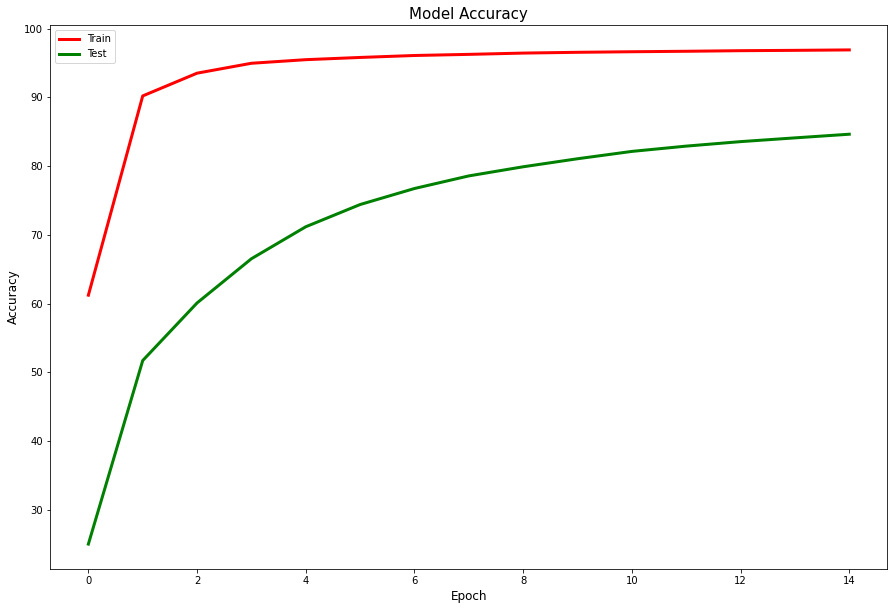

In [30]:
fig = plt.figure(figsize=(15, 10))
plt.plot(log['train_accuracy'], linewidth = 3, color = 'r')
plt.plot(log['test_accuracy'], linewidth = 3, color = 'g')
plt.title('Model Accuracy', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Epoch', fontsize = 12)
plt.legend(['Train', 'Test'], loc='upper left')

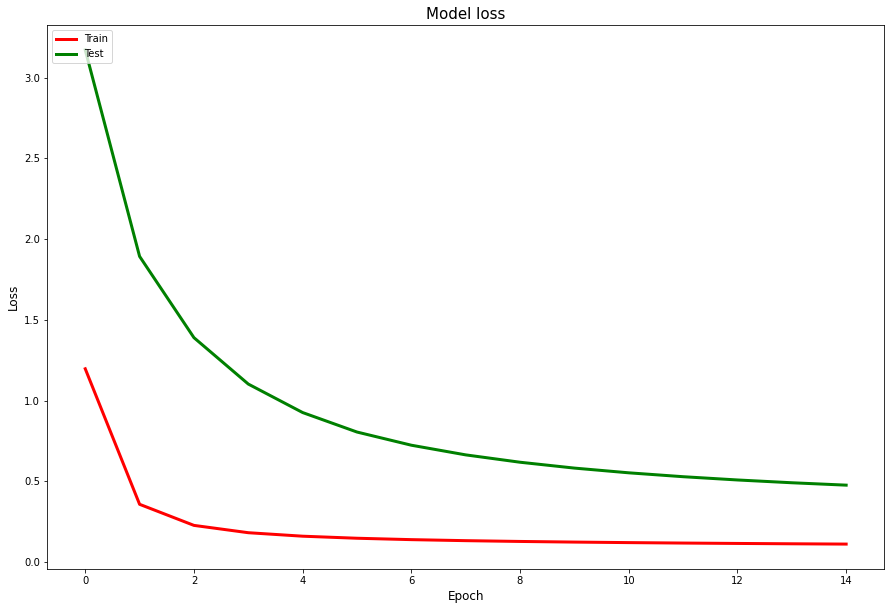

In [31]:
fig = plt.figure(figsize=(15, 10))
plt.plot(log['train_loss'], linewidth = 3, color = 'r')
plt.plot(log['test_loss'], linewidth = 3, color = 'g')
plt.title('Model loss', fontsize = 15)
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoch', fontsize = 12)
plt.legend(['Train', 'Test'], loc='upper left')